In [79]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

root_dir = 'img_align_celeba'
# img_size = (208, 176)

# Define the transformation. You might want to transform the images (e.g., resizing, normalization) for your specific task.
transform = transforms.Compose([
    # transforms.CenterCrop(img_size),
    transforms.ToTensor(), # Convert images to tensor
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize images
])

dataset = ImageFolder(root_dir, transform=transform)
subset = Subset(dataset, range(100))

batch_size = 1
loader = DataLoader(subset, batch_size=batch_size, shuffle=False)

outside_weight = 0.4

In [151]:
for x in loader:
    print(x[0].shape)
    break

[tensor([[[[0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9961, 0.9961],
          [0.9922, 0.9922, 0.9922,  ..., 0.9765, 0.9961, 0.9961],
          [0.9922, 0.9922, 0.9922,  ..., 0.9804, 1.0000, 1.0000],
          ...,
          [0.5490, 0.4549, 0.5725,  ..., 0.4784, 0.4784, 0.4784],
          [0.5098, 0.5412, 0.6510,  ..., 0.4627, 0.4627, 0.4627],
          [0.6588, 0.8000, 0.9608,  ..., 0.4627, 0.4706, 0.4706]],

         [[0.9059, 0.9059, 0.9059,  ..., 0.8863, 0.9333, 0.9333],
          [0.9059, 0.9059, 0.9059,  ..., 0.8941, 0.9333, 0.9333],
          [0.9059, 0.9059, 0.9059,  ..., 0.9059, 0.9373, 0.9373],
          ...,
          [0.2902, 0.1882, 0.3059,  ..., 0.2157, 0.2196, 0.2196],
          [0.2431, 0.2745, 0.3843,  ..., 0.1922, 0.2000, 0.2000],
          [0.3922, 0.5333, 0.6941,  ..., 0.1922, 0.1961, 0.1961]],

         [[0.7608, 0.7608, 0.7608,  ..., 0.8824, 0.8706, 0.8706],
          [0.7608, 0.7608, 0.7608,  ..., 0.8824, 0.8706, 0.8706],
          [0.7608, 0.7608, 0.7608,  ..., 

In [188]:
tensor2img = transforms.ToPILImage()
img = tensor2img(x[0].squeeze())

In [4]:
checkpoint = "vinvino02/glpn-nyu"
depth_estimator = pipeline("depth-estimation", model=checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


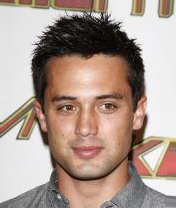

In [77]:
# image = Image.open('img_align_celeba/unlabeled/000002.jpg')
img = dataset[6][0]
# print(type(img))
transform(img)

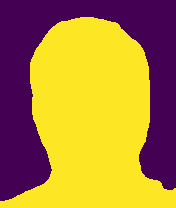

In [78]:
pred = depth_estimator(transform(img))
deps = torch.FloatTensor(np.array(pred['depth']))
salience_map = -deps + 255
fg_mask = salience_map > salience_map.mean()

# colored_data = cm.viridis(yes * 255)

# colored_data

# Image.fromarray((colored_data[:, :, :3] * 255).astype(np.uint8), 'RGB')

In [193]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Maintains 218x178
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 109x89
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Maintains 109x89
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 54x44
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Maintains 54x44
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 27x22
            nn.Flatten(),
            nn.Linear(64 * 27 * 22, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 27 * 22),
            nn.ReLU(),
            nn.Unflatten(1, (64, 27, 22)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 54x44
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 109x89
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=0),  # Outputs 218x178
            nn.Sigmoid()  # Ensures output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class TwoResAutoEncoder(nn.Module):
    def __init__(self, high_latent_dim, low_latent_dim):
        super(TwoResAutoEncoder, self).__init__()
        self.high_res_autoencoder = CNNAutoencoder(high_latent_dim)
        self.low_res_autoencoder = CNNAutoencoder(low_latent_dim)

    def forward(self, image, fg_mask):
        fg_image = image * fg_mask
        bg_image = image * (~fg_mask)
        
        fg_output = self.high_res_autoencoder(fg_image)
        bg_output = self.low_res_autoencoder(bg_image)
        
        return fg_output, bg_output

In [ ]:
model = CNNAutoencoder(latent_dim=64)
x[0].shape
model(x[0])

In [123]:
model = CNNAutoencoder(latent_dim=1000)

# model = TwoResAutoEncoder()
model.train()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
loss_function = nn.MSELoss()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [124]:
# Training loop
num_epochs = 50  
for epoch in range(num_epochs):
    # running_loss = 0.0
    for i, data in enumerate(loader):
        images, _ = data 
        images = images.to(device)
        # saliency_maps = saliency_maps.to(device)
        
        # print(images.shape)
        # Forward pass
        reconstructed_images = model(images)
        # print(reconstructed_images.shape)
        
        # Compute loss
        loss = loss_function(reconstructed_images, images)
        
        # Backward pass and optimize

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.0725
Epoch [2/50], Loss: 0.0654
Epoch [3/50], Loss: 0.0564
Epoch [4/50], Loss: 0.0470
Epoch [5/50], Loss: 0.0391
Epoch [6/50], Loss: 0.0374
Epoch [7/50], Loss: 0.0311
Epoch [8/50], Loss: 0.0257
Epoch [9/50], Loss: 0.0221
Epoch [10/50], Loss: 0.0223
Epoch [11/50], Loss: 0.0175
Epoch [12/50], Loss: 0.0157
Epoch [13/50], Loss: 0.0147
Epoch [14/50], Loss: 0.0136
Epoch [15/50], Loss: 0.0092
Epoch [16/50], Loss: 0.0093
Epoch [17/50], Loss: 0.0088
Epoch [18/50], Loss: 0.0094
Epoch [19/50], Loss: 0.0084
Epoch [20/50], Loss: 0.0084
Epoch [21/50], Loss: 0.0098
Epoch [22/50], Loss: 0.0113
Epoch [23/50], Loss: 0.0063
Epoch [24/50], Loss: 0.0075
Epoch [25/50], Loss: 0.0097
Epoch [26/50], Loss: 0.0114
Epoch [27/50], Loss: 0.0080
Epoch [28/50], Loss: 0.0112
Epoch [29/50], Loss: 0.0057
Epoch [30/50], Loss: 0.0048
Epoch [31/50], Loss: 0.0047
Epoch [32/50], Loss: 0.0072
Epoch [33/50], Loss: 0.0049
Epoch [34/50], Loss: 0.0054
Epoch [35/50], Loss: 0.0043
Epoch [36/50], Loss: 0.0090
E

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def show_pair(img):
    plt.figure(figsize=(10, 5)) 
    plt.subplot(121)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    
    reconstruction = model(img.to(device).unsqueeze(0)).squeeze(0).to('cpu').detach()
    plt.subplot(122)
    plt.imshow(torch.permute(reconstruction, (1, 2, 0)))

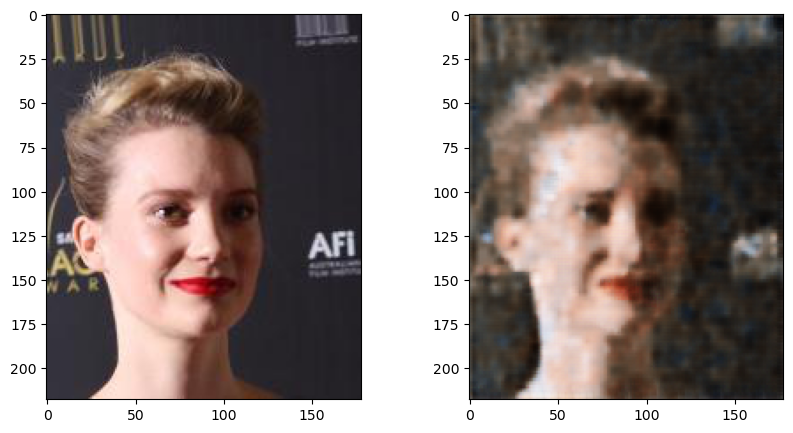

In [284]:
model = torch.load('baseline1000.pt')
show_pair(dataset[99][0])

In [174]:
test_img = torch.FloatTensor(np.array(Image.open('img_align_celeba/full/img_align_celeba/000103.jpg')))
test_img = test_img.permute(2,0,1) / 255

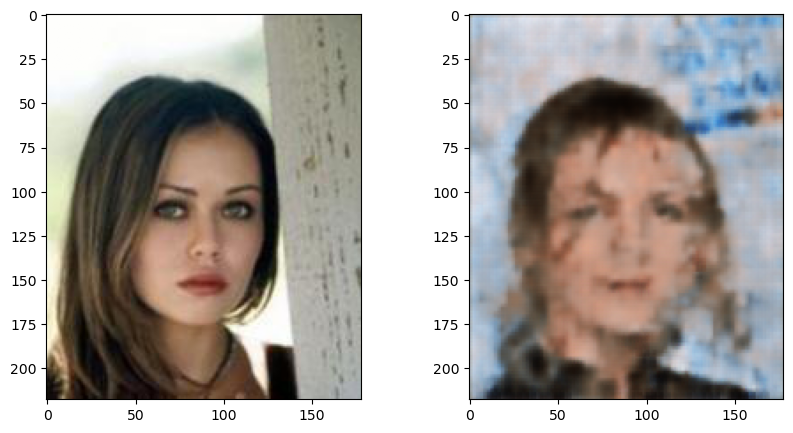

In [175]:
show_pair(test_img)

In [173]:
torch.save(model, 'baseline1000.pt')

In [283]:
import gc
torch.cuda.empty_cache()
gc.collect()

100595

In [212]:
model = TwoResAutoEncoder(900, 100)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.train()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='none')

In [239]:
num_epochs = 50
for epoch in range(num_epochs):
    total_fg_loss = 0.0
    total_bg_loss = 0.0
    for data in loader:
        images, _ = data
        bruh = tensor2img(images.squeeze())

        pred = depth_estimator(bruh)
        deps = torch.FloatTensor(np.array(pred['depth']))
        salience_map = -deps + 255
        fg_mask = salience_map > salience_map.mean()

        # Forward pass
        images = images.to(device)
        fg_mask = fg_mask.to(device)
        optimizer.zero_grad()
        fg_output, bg_output = model(images, fg_mask)


        # Calculate the loss for each region
        fg_loss = criterion(fg_output, images) * fg_mask
        bg_loss = criterion(bg_output, images) * (~fg_mask)

        # Only consider masked areas by averaging non-zero entries
        fg_loss = fg_loss.sum() / fg_mask.sum()
        bg_loss = bg_loss.sum() / (~fg_mask).sum()

        # Combine losses and perform backpropagation
        total_loss = fg_loss + bg_loss
        total_loss.backward()
        optimizer.step()

        # Aggregate losses for logging
        total_fg_loss += fg_loss.item()
        total_bg_loss += bg_loss.item()

    # Print epoch loss
    avg_fg_loss = total_fg_loss / len(loader)
    avg_bg_loss = total_bg_loss / len(loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Foreground Loss: {avg_fg_loss:.4f}, Background Loss: {avg_bg_loss:.4f}')


Epoch 1/50, Foreground Loss: 0.0600, Background Loss: 0.0719
Epoch 2/50, Foreground Loss: 0.0516, Background Loss: 0.0789
Epoch 3/50, Foreground Loss: 0.0453, Background Loss: 0.0746
Epoch 4/50, Foreground Loss: 0.0394, Background Loss: 0.0699
Epoch 5/50, Foreground Loss: 0.0367, Background Loss: 0.0613
Epoch 6/50, Foreground Loss: 0.0355, Background Loss: 0.0699
Epoch 7/50, Foreground Loss: 0.0351, Background Loss: 0.0803
Epoch 8/50, Foreground Loss: 0.0356, Background Loss: 0.0652
Epoch 9/50, Foreground Loss: 0.0331, Background Loss: 0.0552
Epoch 10/50, Foreground Loss: 0.0307, Background Loss: 0.0521
Epoch 11/50, Foreground Loss: 0.0290, Background Loss: 0.0496
Epoch 12/50, Foreground Loss: 0.0282, Background Loss: 0.0496
Epoch 13/50, Foreground Loss: 0.0255, Background Loss: 0.0497
Epoch 14/50, Foreground Loss: 0.0264, Background Loss: 0.0506
Epoch 15/50, Foreground Loss: 0.0253, Background Loss: 0.0529
Epoch 16/50, Foreground Loss: 0.0237, Background Loss: 0.0551
Epoch 17/50, Fore

In [285]:
def show_pair2(img):
    # plt.figure(figsize=(10, 5)) 
    # plt.subplot(121)
    # plt.imshow(torch.permute(img, (1, 2, 0)))
    
    
    # # images, _ = data
    # bruh = tensor2img(img.squeeze())

    # pred = depth_estimator(bruh)
    # deps = torch.FloatTensor(np.array(pred['depth']))
    # salience_map = -deps + 255
    # fg_mask = salience_map > salience_map.mean()

    # fg_mask = fg_mask.to(device)
    
    # fg_rec, bg_rec = model(img.to(device).unsqueeze(0), fg_mask)
    # fg_rec = fg_rec.to('cpu').squeeze().detach()
    # bg_rec = bg_rec.to('cpu').squeeze().detach()

    # # print(fg_rec.shape)
    # # fg_rec = fg_rec.to('cpu').squeeze().detach()
    # fg_mask = fg_mask.to('cpu')
    # # print(fg_mask)
    # full_rec = fg_rec * fg_mask + bg_rec * (~fg_mask)

    # print(full_rec.shape)
    # # breakpoint()
    # plt.subplot(122)
    # plt.imshow(torch.permute(full_rec, (1, 2, 0)))
    plt.figure(figsize=(15, 5))  # Adjust the figure size to accommodate three subplots
    
    # Display the original image
    plt.subplot(131)  # 1 row, 3 columns, 1st subplot
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.title('Original Image')

    # Generate the foreground mask
    bruh = tensor2img(img.squeeze())  # Ensure tensor2img function is defined to convert tensor to image format
    pred = depth_estimator(bruh)
    deps = torch.FloatTensor(np.array(pred['depth']))
    salience_map = -deps + 255
    fg_mask = salience_map > salience_map.mean()
    fg_mask = fg_mask.to(device)

    # Display the foreground mask
    plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
    plt.imshow(fg_mask.cpu(), cmap='gray')  # Display mask in grayscale
    plt.title('Foreground Mask')

    # Process the image through the model to get foreground and background reconstructions
    fg_rec, bg_rec = model(img.to(device).unsqueeze(0), fg_mask)
    fg_rec = fg_rec.to('cpu').squeeze().detach()
    bg_rec = bg_rec.to('cpu').squeeze().detach()

    # Combine foreground and background using the mask
    full_rec = fg_rec * fg_mask.to('cpu') + bg_rec * (~fg_mask.to('cpu'))

    # Display the combined reconstruction
    plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
    plt.imshow(torch.permute(full_rec, (1, 2, 0)))
    plt.title('Combined Reconstruction')

    plt.show()

In [286]:
model = torch.load('twores900.pt')

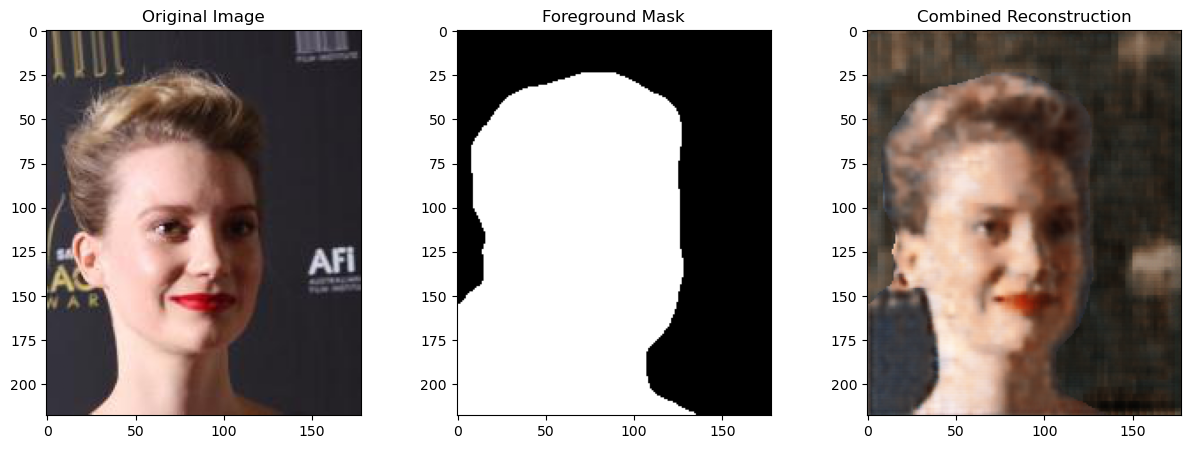

In [287]:
show_pair2(dataset[99][0])

In [243]:
# torch.save(model, 'twores900.pt')